In [14]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import glob

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
DATA_DIR = os.path.join(os.path.abspath(".."), "cons454_project/data/")

In [6]:
# Attribution: [Code from PyTorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning)

IMAGE_LENGTH = 711
IMAGE_WIDTH = 400

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_WIDTH, IMAGE_LENGTH)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ]
    ),
    "valid": transforms.Compose(
        [
            transforms.Resize((IMAGE_WIDTH, IMAGE_LENGTH)),                        
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),                        
        ]
    ),
}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
    for x in ["train", "valid"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=24, shuffle=True, num_workers=4
    )
    for x in ["train", "valid"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid"]}
class_names = image_datasets["train"].classes

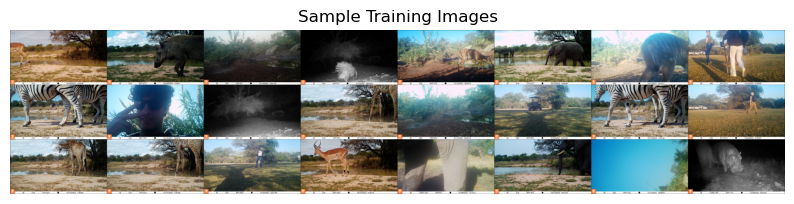

In [7]:
inputs, classes = next(iter(dataloaders["train"]))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [10]:
def get_features(model, train_loader, valid_loader):
    with torch.no_grad():
        Z_train = torch.empty((0, 1024))
        y_train = torch.empty((0))
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))
        for X, y in train_loader:
            Z_train = torch.cat((Z_train, model(X)), dim=0)
            y_train = torch.cat((y_train, y))
        for X, y in valid_loader:
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))
    return Z_train.detach(), y_train.detach(), Z_valid.detach(), y_valid.detach()

In [11]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = nn.Identity()  # remove last "classification" layer

In [12]:
Z_train, y_train, Z_valid, y_valid = get_features(
    densenet, dataloaders["train"], dataloaders["valid"]
)

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [500, 1000, 2000, 3000, 4000]
}

clf = LogisticRegression()
grid = GridSearchCV(clf, param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(Z_train.numpy(), y_train.numpy())

print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'C': 10, 'max_iter': 500}


In [36]:
pd.DataFrame(grid.cv_results_)[
    [
        "mean_test_score",
        "param_C", 
        "param_max_iter",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,1,1,1,1,1,1,1,1,1,...,16,16,16,16,16,21,21,21,21,21
mean_test_score,0.930000,0.930000,0.930000,0.930000,0.930000,0.930000,0.930000,0.930000,0.930000,0.930000,...,0.900000,0.900000,0.90000,0.900000,0.900000,0.830000,0.830000,0.830000,0.830000,0.830000
param_C,100.000000,100.000000,100.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,...,0.100000,0.100000,0.10000,0.100000,0.100000,0.010000,0.010000,0.010000,0.010000,0.010000
param_max_iter,4000.000000,2000.000000,1000.000000,500.000000,4000.000000,3000.000000,2000.000000,1000.000000,500.000000,3000.000000,...,4000.000000,3000.000000,2000.00000,1000.000000,500.000000,4000.000000,3000.000000,2000.000000,1000.000000,500.000000
mean_fit_time,0.152129,0.238533,0.112162,0.076658,0.201198,0.144421,0.128181,0.125583,0.047122,0.244223,...,0.199206,0.155904,0.17602,0.195999,0.146323,0.096896,0.112978,0.120029,0.143306,0.077784


In [39]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=3000, C=10))
pipe.fit(Z_train, y_train)
pipe.score(Z_train.numpy(), y_train.numpy())

1.0

In [40]:
pipe.score(Z_valid.numpy(), y_valid.numpy())

0.86

In [41]:
class_names

['animals', 'nothing', 'people']

In [42]:
pred = pipe.predict(Z_valid.numpy())
results = pd.DataFrame({
    'Predicted': pred,
    'Actual': y_valid
})

print(results)

    Predicted  Actual
0         0.0     0.0
1         0.0     0.0
2         0.0     0.0
3         0.0     0.0
4         0.0     0.0
5         0.0     0.0
6         0.0     0.0
7         0.0     0.0
8         0.0     0.0
9         0.0     0.0
10        0.0     0.0
11        0.0     0.0
12        0.0     0.0
13        2.0     1.0
14        0.0     0.0
15        2.0     2.0
16        1.0     0.0
17        0.0     0.0
18        0.0     0.0
19        0.0     1.0
20        0.0     0.0
21        0.0     0.0
22        0.0     0.0
23        1.0     1.0
24        0.0     0.0
25        0.0     0.0
26        0.0     0.0
27        0.0     0.0
28        0.0     0.0
29        2.0     2.0
30        0.0     2.0
31        0.0     0.0
32        0.0     1.0
33        1.0     1.0
34        0.0     0.0
35        0.0     0.0
36        2.0     2.0
37        0.0     0.0
38        0.0     0.0
39        0.0     0.0
40        0.0     0.0
41        0.0     1.0
42        0.0     0.0
43        0.0     0.0
44        